# Import Libraries

In [34]:
from keras import backend as K
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.datasets import boston_housing
from keras import layers
from keras.initializers import Initializer
from sklearn.cluster import KMeans
import time
from sklearn.preprocessing import StandardScaler
import keras_tuner as kt
from tensorflow.keras.callbacks import EarlyStopping

# Definition of the RBF Layer
The code is based on the implementation of Petra Vidnerova et. all, which can be found [here](https://github.com/PetraVidnerova/rbf_keras). Also, the [Keras Tutorial on creating a custom layer](https://www.tutorialspoint.com/keras/keras_customized_layer.htm) is followed.

In [35]:
class RBFLayer(layers.Layer):
    # output_dim: number of hidden units (number of outputs of the layer)
    # initializer: instance of initializer to initialize centers
    # betas: float, initial value for betas (beta = 1 / 2*pow(sigma,2))
    def __init__(self, output_dim, initializer, betas=1.0, **kwargs):
        self.betas = betas
        self.output_dim = output_dim
        self.initializer = initializer
        super(RBFLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.centers = self.add_weight(name='centers', shape=(self.output_dim, input_shape[1]),
                                       initializer=self.initializer, trainable=False)
        sigma = np.zeros(self.output_dim)
        for i in range(0, self.output_dim):
            d_max = 0
            for j in range(0, self.output_dim):
                d = np.linalg.norm(self.centers[i] - self.centers[j])
                if d > d_max:
                    d_max = d
            sigma[i] = d_max / np.sqrt(2 * self.output_dim)
        self.betas = np.ones(self.output_dim) / (2 * (sigma ** 2))
        super(RBFLayer, self).build(input_shape)

    def call(self, inputs, *args, **kwargs):
        C = tf.expand_dims(self.centers, -1)  
        H = tf.transpose(C - tf.transpose(inputs))  
        return tf.exp(-self.betas * tf.math.reduce_sum(H ** 2, axis=1))

    def compute_output_shape(self, input_shape):
        return input_shape[0], self.output_dim

## KMeans Definition for the Centers
Petra Vinderova also implements the [KMeans Initialiser](https://github.com/PetraVidnerova/rbf_keras/blob/master/kmeans_initializer.py)

In [36]:
class InitCentersKMeans(Initializer):
    def __init__(self, X, max_iter=100):
        self.X = X
        self.max_iter = max_iter
        super().__init__()

    def __call__(self, shape, dtype=None, *args):
        assert shape[1] == self.X.shape[1]
        n_centers = shape[0]
        km = KMeans(n_clusters=n_centers, max_iter=self.max_iter, verbose=0)
        km.fit(self.X)
        return km.cluster_centers_


## Definition of the necessary metrics
The following metrics are based on these implementations:
- [R2 score](https://jmlb.github.io/ml/2017/03/20/CoeffDetermination_CustomMetric4Keras/)
- [Root Mean Squared Error](https://stackoverflow.com/questions/43855162/rmse-rmsle-loss-function-in-keras) / and this [issue](https://github.com/keras-team/keras/issues/10706)
- [Mean Squared Error](https://stackoverflow.com/questions/67216102/keras-mean-squared-error-mse-calculation-definition-for-images)

In [37]:
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))


def mean_squared_error(y_true, y_pred):
    return K.mean(K.square(y_pred - y_true))


def r2_score(y_true, y_pred):
    SS_res = K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return 1 - SS_res/(SS_tot + K.epsilon())

## Other Functions that will be used

In [38]:
def data_normalisation(data):
    encoder = StandardScaler()
    return encoder.fit_transform(data)

def split_validation(data, length_training, length_validation):
    data_train, data_validation = tf.split(data, [length_training, length_validation], 0)
    return data_train, data_validation

## Data Preprocessing

In [39]:
test_length = 0.25
(x_train, y_train), (x_test, y_test) = boston_housing.load_data(test_split=test_length)

normalise = True
if normalise:
    x_train = data_normalisation(x_train)
    x_test = data_normalisation(x_test)

## Parameters

In [40]:
length_validation = 0.2

learning_rate = 0.001
epochs = 20
batch_size = 4

neurons_percentage = [0.05, 0.15, 0.3, 0.5]
total_neurons_rbf = [round(n*0.8*x_train.shape[0]) for n in neurons_percentage]
total_neurons_hidden2 = [32, 64, 128, 256]
total_dropout_probabilities = [0.2, 0.35, 0.5]
neurons_output = 1

## Build Model

In [41]:
def build_model(hp):
    
    neurons_rbf = hp.Choice('neurons_rbf', values=total_neurons_rbf)
    neurons_hidden2 = hp.Choice('neurons_hidden2', values=total_neurons_hidden2)
    dropout_probability = hp.Choice('dropout_probability', values=total_dropout_probabilities)
    
    model = Sequential()
    model.add(RBFLayer(neurons_rbf, initializer=InitCentersKMeans(x_train), input_shape=(13, )))
    model.add(Dense(neurons_hidden2))
    model.add(Dropout(dropout_probability))
    model.add(Dense(neurons_output))
    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate), loss=mean_squared_error, 
                  metrics=[r2_score, root_mean_squared_error])
    return model

## Define the Tuner

In [42]:
tuner = kt.RandomSearch(
    build_model, objective=kt.Objective("val_root_mean_squared_error", direction='min'))

early_stopping = EarlyStopping(
    monitor="loss",
    patience=200,
    restore_best_weights=True)

## Tune the model

In [43]:
tuner.search(x_train, y_train,
             epochs=epochs,
             validation_split=length_validation,
             callbacks=[early_stopping])

## Get the optimal parameters

In [44]:
optimal_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

neurons_rbf = optimal_hyperparameters.get('neurons_rbf')
neurons_hidden2 = optimal_hyperparameters.get('neurons_hidden2')
dropout_probability = optimal_hyperparameters.get('dropout_probability')

print(f'Best number of neurons in the RBF layer: ' +str(neurons_rbf))
print(f'Best number of neurons in the second hidden layer: ' +str(neurons_hidden2))
print(f'Best value for the dropout probability: ' +str(dropout_probability))

Best number of neurons in the RBF layer: 152
Best number of neurons in the second hidden layer: 64
Best value for the dropout probability: 0.5


## Build the tuned model

In [45]:
tuned_model = Sequential()
model = Sequential()
model.add(RBFLayer(neurons_rbf, initializer=InitCentersKMeans(x_train), input_shape=(13, )))
model.add(Dense(neurons_output))
model.add(Dropout(dropout_probability))
model.add(Dense(neurons_output))
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate), loss=mean_squared_error, metrics=[r2_score, root_mean_squared_error])

fit_model = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=length_validation, verbose=0)
score = model.evaluate(x_test, y_test)

4/4 [==============================] - 0s 3ms/step - loss: 74.5166 - r2_score: 0.0096 - root_mean_squared_error: 8.4182


## Plot the results

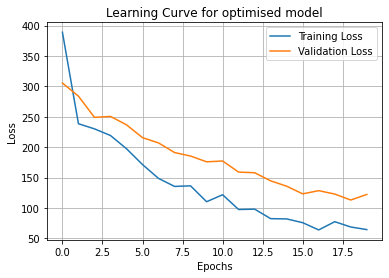

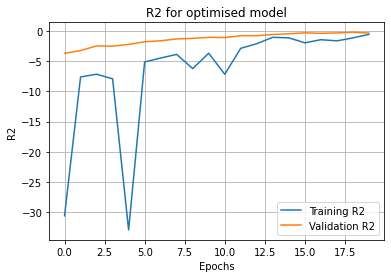

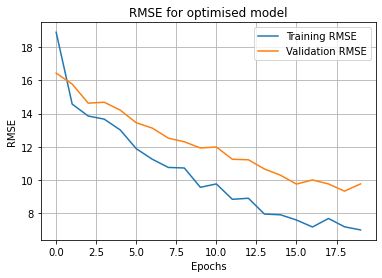

In [46]:

train_loss = fit_model.history['loss']
validation_loss = fit_model.history['val_loss']

train_r2 = fit_model.history['r2_score']
validation_r2 = fit_model.history['val_r2_score']

train_rmse = fit_model.history['root_mean_squared_error']
validation_rmse = fit_model.history['val_root_mean_squared_error']

plt.plot(train_loss)
plt.plot(validation_loss)

plt.title('Learning Curve for optimised model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.grid()
plt.show()

plt.plot(train_r2)
plt.plot(validation_r2)

plt.title('R2 for optimised model')
plt.xlabel('Epochs')
plt.ylabel('R2')
plt.legend(['Training R2', 'Validation R2'], loc='lower right')
plt.grid()
plt.show()

plt.plot(train_rmse)
plt.plot(validation_rmse)

plt.title('RMSE for optimised model')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend(['Training RMSE', 'Validation RMSE'], loc='upper right')
plt.grid()
plt.show()
